# 实验一：手动实现循环神经网络RNN
姓名：王恩泰

学号：21114019

In [27]:
import os
import numpy as np
import torch
import math
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.utils.data as Data
import torch.nn.functional as F
import torch.nn as nn
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

## 1. 读取数据集

In [28]:
dataset = np.load('./高速公路传感器数据/PEMS04/PEMS04.npz')["data"]
# data的三个特征：车流量，拥挤程度，车速
# dataset['data'] 
print(dataset.shape)

# 划分训练集与测试集，将原始数据分割为长序列
train_proportation = 0.6
train_seqs = dataset[:int(dataset.shape[0]*train_proportation)]
test_seqs = dataset[int(dataset.shape[0]*train_proportation):]
print(train_seqs.shape)
print(test_seqs.shape)

# 采用固定长度滑动窗口处理时间序列数据，将长序列改成短序列
train_dataset = []
test_dataset = []
window_size = 12
feature_dim = 0
 
for i in range(train_seqs.shape[0]- window_size):
    train_dataset.append(train_seqs[i:i+window_size, :10, feature_dim])
train_dataset = np.concatenate(train_dataset,axis=1).transpose() # 按列拼接并转置
print(train_dataset.shape)

for i in range(test_seqs.shape[0]- window_size):
    test_dataset.append(test_seqs[i:i+window_size, :10, feature_dim])
test_dataset = np.concatenate(test_dataset[:],axis=1).transpose() # 按列拼接并转置
print(test_dataset.shape)


(16992, 307, 3)
(10195, 307, 3)
(6797, 307, 3)
(101830, 12)
(67850, 12)


## 2. 归一化训练集、测试集

In [29]:
def normalize(data):
    mu = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data-mu)/std

train_dataset = normalize(train_dataset)
test_dataset = normalize(train_dataset) 
# 为什么要归一化？

## 3. 定义RNN类
$h_{t}=\sigma\left(W_{h} x_{t}+U_{h} h_{t-1}+b_{h}\right) \\
y_{t}=\sigma\left(W_{y} h_{t}+b_{y}\right)$


In [30]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # super(MyRNN, self).__init__()  # 继承父类
        super().__init__()  # 继承父类
        self.hidden_size = hidden_size

        # W_h: 隐含层h输入x权重(从输入层到隐含层)
        self.W_h = nn.Parameter(torch.rand(input_size, hidden_size))

        # U_h：隐含层h转移t->t+1权重(两个隐含层间)
        self.U_h = nn.Parameter(torch.rand(hidden_size,hidden_size))

        # b_h: 隐含层h转移偏置
        self.b_h = nn.Parameter(torch.zeros(hidden_size))

        # W_y: 输出y的权重
        self.W_y = nn.Parameter(torch.rand(hidden_size,output_size))

        # b_y: 输出y的偏置
        self.b_y = nn.Parameter(torch.zeros(output_size))

        # 隐含层转移激活函数
        self.tanh = nn.Tanh()

        # 输出激活函数
        self.leaky_relu = nn.LeakyReLU()

        # 可选：使用性能更好的参数初始化函数
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        # print(x.size)
        batch_size = x.size(0) # 0是行数，即数据条目数
        seq_len = x.size(1) # 1是列数，即一条数据有几个时间点数据

        # 初始化一个用于下一个阶段预测的隐含层状态
        # 初始化隐藏状态，一般设为全0。由于是内部新建的变量，需要同步设备位置。
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)

        # RNN实际上只能一步一步处理序列。因此需要用循环迭代。
        y_list = []
        # x第0维是数据条目数，第1维是每条数据有12个时间点，第2维是每个时间点有3个属性
        for i in range(seq_len): # 对每个时间点循环
            h = self.tanh(torch.matmul(x[:, i, :], self.W_h) + torch.matmul(h, self.U_h) + self.b_h)  
            # (batch_size, hidden_size)
            y = self.leaky_relu(torch.matmul(h, self.W_y) + self.b_y)  
            # y = torch.matmul(h, self.W_y) + self.b_y
            # (batch_size, output_size)
        y_list.append(y)

        return h, torch.stack(y_list,dim=1)
        # torch.stack: 将每个矩阵的第一行组成第一维矩阵，依次下去,每个矩阵的第n行组成第n维矩阵

## 3. 定义各类损失函数
$$
M A P E=\frac{100 \%}{n} \sum_{i=1}^{n}\left|\frac{\hat{y}_{i}-y_{i}}{y_{i}}\right|
$$

$$
R M S E=\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\hat{y}_{i}-y_{i}\right)^{2}}
$$

$$
M A E=\frac{1}{n} \sum_{i=1}^{n}\left|\hat{y}_{i}-y_{i}\right|
$$


In [31]:
def MAPE(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    non_zero_index = (y_true > 0) # 获取>0的index
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

## 4. 初始化模型参数

In [32]:
device = 'cpu'
net = MyRNN(input_size=1, hidden_size=64, output_size=1).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
batch_size = 64
max_epoch_num = 30

g_MSE_list_train, g_MSE_list_test = [], []
g_MAE_list_test= []
g_RMSE_list_test= []
g_MAPE_list_test= []

## 5. 训练及测试

In [33]:
def next_batch(data):
    data_length = len(data)
    num_batches = math.ceil(data_length/batch_size)
    # 生成每一个batch的数据
    for batch_index in range(num_batches):
        # 取相应区间内的数据
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, data_length)
        yield data[start_index:end_index]

# 反归一化
def denormalize(data):
    min_v, max_v = data.min(), data.max()
    return data * (max_v - min_v) + min_v

def train_epoch(net, train_dataset, device): # 一个epoch的程序
    train_batch_num = len(train_dataset)
    total_mse_loss = 0
    all_prediction = []

    for batch in next_batch(shuffle(train_dataset)):
        batch = torch.from_numpy(batch).float().to(device)
        # 短序列前12为输入，最后一个为预测
        x_train = batch[:,:12] # y一个短序列是12个时间点
        y_train = batch[:, -1] # 最后一个数是y
        # print(x_train.shape)   
        # print(y_train.shape)  

        # 取出来预测的y
        last_hidden, y_predict = net(x_train.unsqueeze(-1))
        y_prediction = y_predict[:,-1,:].squeeze(-1)
        all_prediction.append(y_prediction.detach().cpu().numpy())

        loss = loss_func(y_prediction, y_train)
        total_mse_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    y_predict = np.concatenate(all_prediction)
    y_train = train_dataset[:, -1]

    # 反归一化
    y_train = denormalize(y_train)
    y_predict = denormalize(y_predict)

    return total_mse_loss

def test_epoch(net, test_dataset, device):
    test_batch_num = len(test_dataset)
    total_mse_loss = 0
    total_mae_loss = 0
    total_rmse_loss = 0
    total_mape_loss = 0
    all_prediction = []

    for batch in next_batch(test_dataset):
        batch = torch.from_numpy(batch).float().to(device)
        x_test = batch[:,:12] # y一个短序列是12个时间点
        y_test = batch[:, -1] # 最后一个数是y

        # 取出来预测的y
        last_hidden, y_predict = net(x_test.unsqueeze(-1))
        y_prediction = y_predict[:,-1,:].squeeze(-1)

        loss = loss_func(y_prediction, y_test)
        total_mse_loss += loss
        all_prediction.append(y_prediction.detach().cpu().numpy())

    y_predict = np.concatenate(all_prediction)
    y_test = test_dataset[:, -1]

    # 反归一化
    y_test = denormalize(y_test)
    y_predict = denormalize(y_predict)
    
    mse_test = total_mse_loss
    mae_test = mae(y_test, y_predict)
    rmse_test = math.sqrt(mse(y_test, y_predict))
    mape_test = MAPE(y_test, y_predict)
    
    return mse_test, mae_test, rmse_test, mape_test

## 6. 主函数

Train Epoch: 0, Loss(MSE): 571.4762
Test Epoch: 0, Loss(MSE): 434.5491, RMSE: 2.7479, MAE: 3.6167, MAPE: 87.3142
Train Epoch: 1, Loss(MSE): 782.3856
Test Epoch: 1, Loss(MSE): 650.7404, RMSE: 3.2707, MAE: 4.1992, MAPE: 55.6781
Train Epoch: 2, Loss(MSE): 648.4422
Test Epoch: 2, Loss(MSE): 643.8505, RMSE: 3.2469, MAE: 4.1780, MAPE: 59.7950
Train Epoch: 3, Loss(MSE): 636.2701
Test Epoch: 3, Loss(MSE): 626.4760, RMSE: 3.1994, MAE: 4.1352, MAPE: 61.2287
Train Epoch: 4, Loss(MSE): 613.2888
Test Epoch: 4, Loss(MSE): 596.5909, RMSE: 3.0850, MAE: 4.0369, MAPE: 65.2897
Train Epoch: 5, Loss(MSE): 545.7440
Test Epoch: 5, Loss(MSE): 454.8804, RMSE: 2.6867, MAE: 3.5972, MAPE: 78.4013
Train Epoch: 6, Loss(MSE): 375.6138
Test Epoch: 6, Loss(MSE): 304.7792, RMSE: 2.3144, MAE: 3.0429, MAPE: 99.2246
Train Epoch: 7, Loss(MSE): 425.0533
Test Epoch: 7, Loss(MSE): 308.9660, RMSE: 2.3677, MAE: 3.1460, MAPE: 64.3591
Train Epoch: 8, Loss(MSE): 554.0146
Test Epoch: 8, Loss(MSE): 651.8551, RMSE: 3.3548, MAE: 4.327

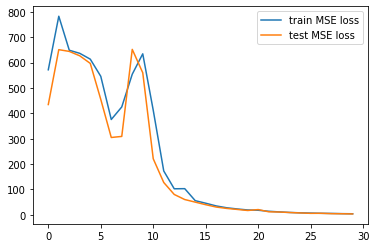

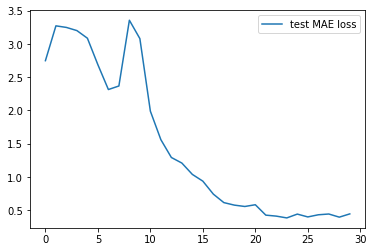

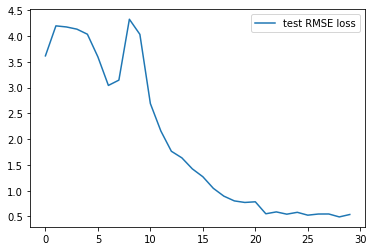

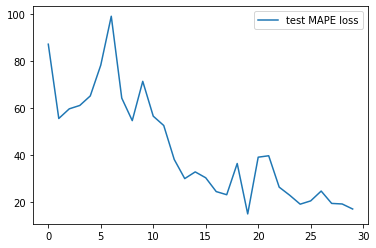

In [34]:
for epoch in range(max_epoch_num):
    mse_train = train_epoch(net, train_dataset, device)
    g_MSE_list_train.append(float(mse_train))
    print('Train Epoch: %d, Loss(MSE): %.4f' % (epoch, mse_train))

    mse_test, mae_test, rmse_test, mape_test = test_epoch(net, test_dataset, device)
    g_MSE_list_test.append(float(mse_test))
    g_MAE_list_test.append(mae_test)
    g_RMSE_list_test.append(rmse_test)
    g_MAPE_list_test.append(mape_test)
    print('Test Epoch: %d, Loss(MSE): %.4f, RMSE: %.4f, MAE: %.4f, MAPE: %.4f' % 
    (epoch, mse_test, mae_test, rmse_test, mape_test))


plt.plot(g_MSE_list_train, label='train MSE loss')
plt.plot(g_MSE_list_test, label='test MSE loss')
plt.legend() 
plt.show()     

plt.plot(g_MAE_list_test, label='test MAE loss')
plt.legend() 
plt.show()     

plt.plot(g_RMSE_list_test, label='test RMSE loss')
plt.legend() 
plt.show()   

plt.plot(g_MAPE_list_test, label='test MAPE loss')
plt.legend() 
plt.show() 